In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import warnings
from tqdm import tqdm

# Modelli e metriche
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              GradientBoostingClassifier, GradientBoostingRegressor, 
                              AdaBoostClassifier, BaggingClassifier, BaggingRegressor)
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Funzioni di visualizzazione e modelli
from visualization.custom_plots import day_of_year_to_date
from models.classifier import X_labels, train, predict_custom

# Suppress warnings
warnings.filterwarnings("ignore")

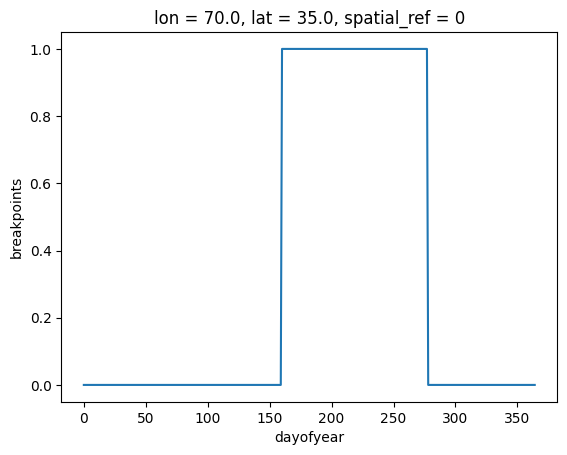

In [2]:
dataset = xr.open_dataset("/home/jgrassi/work/XSeasonsDetect/INDIA/results/files/monsoon_no_temp.nc")

lables_param = {
    'n_seas': 2
}

dates_clust = X_labels(dataset['breakpoints'], **lables_param)

# Verifica il risultato
dates_clust.sel(lat=35, lon=70, method='nearest').plot()

In [3]:
## TRAIN Dataset

train_paths = [
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/ERA5/total_precipitation/final.nc',
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/ERA5/u850/final.nc',
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/ERA5/v850/final.nc'
]

train_codes = [
    'tp', 'u', 'v'
]


dataset_train = []

for path, code in zip(train_paths, train_codes):
    dataset_train.append(xr.open_dataset(path)[code])

if len(dataset_train) > 1:
    
    for j in range(1, len(dataset_train)):
        dataset_train[j]['time'] = dataset_train[0]['time']

dataset_train = xr.merge(dataset_train)


#dataset_train = (dataset_train - dataset_train.min(dim='time')) / (dataset_train.max(dim='time') - dataset_train.min(dim='time'))
dataset_train = (dataset_train - dataset_train.mean(dim='time')) / dataset_train.std(dim='time')

index_values = dates_clust.values
index_values = np.tile(index_values, 57).transpose((2, 0, 1))
dataset_train['labels'] = (('time', 'lat', 'lon'), index_values)


array_train  = dataset_train.to_array().values.transpose()
array_train.shape

(36, 36, 20805, 4)

In [4]:
# Project dataset

proj_paths = [
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/CMIP6/EC-Earth3/historical/total_precipitation/final.nc',
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/CMIP6/EC-Earth3/historical/u850/final.nc',
    '/home/jgrassi/work/XSeasonsDetect/INDIA/data/preprocessed/CMIP6/EC-Earth3/historical/v850/final.nc'
]


proj_codes = [
    'pr', 'ua', 'va'
]

dataset_proj = xr.merge([xr.open_dataset(path)[code] for path, code in zip(proj_paths, proj_codes)]).mean('plev')


#dataset_res = (dataset_res - dataset_res.min(dim='time')) / (dataset_res.max(dim='time') - dataset_res.min(dim='time'))
dataset_proj = (dataset_proj - dataset_proj.mean(dim='time')) / dataset_proj.std(dim='time')

In [5]:
data = array_train

# MODELS 

# Logistic Regression
model = LogisticRegression(random_state=0)

# # Random Forest Classifier
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Support Vector Classifier (SVC)
# model = SVC(kernel='linear', random_state=42)

# K-Nearest Neighbors (KNN)
# model = KNeighborsClassifier(n_neighbors=5)

# Gradient Boosting Classifier
# model = GradientBoostingClassifier(random_state=42)

# Naive Bayes
# model = GaussianNB()
 
# AdaBoost Classifier
# model = AdaBoostClassifier(n_estimators=5, random_state=42)

# Neural Network Classifier (MLP)
# model = MLPClassifier(hidden_layer_sizes=(32,), max_iter=50, random_state=42)




mse, r2, models = train(data, model=model)

dataset_model = xr.Dataset(
    {
        'mse': (('lat', 'lon'), mse),
        'r2': (('lat', 'lon'), r2),
        'model': (('lat', 'lon'), models)
    },
    coords={
        'lat': dataset_train['lat'],
        'lon': dataset_train['lon']
    }
)

dataset_model.attrs['description'] = 'Model trained on the dataset with the labels obtained from XSeas_detect'
dataset_model.attrs['model'] = model

dataset_model.mse.attrs['long_name'] = 'Mean Squared Error'
dataset_model.r2.attrs['long_name'] = 'R2 Score'
dataset_model.model.attrs['long_name'] = 'Model'

100%|██████████| 36/36 [00:08<00:00,  4.37it/s]


In [6]:
dataset_model

<xarray.Dataset>
Dimensions:      (lat: 36, lon: 36)
Coordinates:
  * lat          (lat) float64 5.0 6.0 7.0 8.0 9.0 ... 36.0 37.0 38.0 39.0 40.0
    spatial_ref  int64 0
  * lon          (lon) float64 65.0 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
Data variables:
    mse          (lat, lon) float64 nan nan nan nan ... 0.2598 0.1961 0.1831
    r2           (lat, lon) float64 nan nan nan nan ... -0.2622 -0.1809 -0.08559
    model        (lat, lon) object None ... LogisticRegression(random_state=0)
Attributes:
    description:  Model trained on the dataset with the labels obtained from ...
    model:        LogisticRegression(random_state=0)

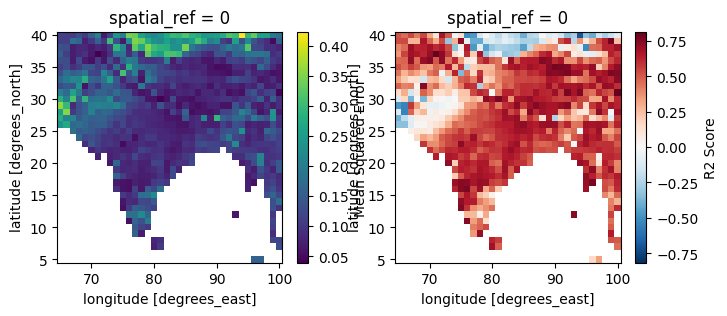

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

dataset_model.mse.plot(ax=ax[0])
dataset_model.r2.plot(ax=ax[1])

In [8]:
array_res  = dataset_proj.to_array().values.transpose()
predictions = predict_custom(array_res, dataset_model.model)

100%|██████████| 36/36 [00:00<00:00, 71.43it/s] 


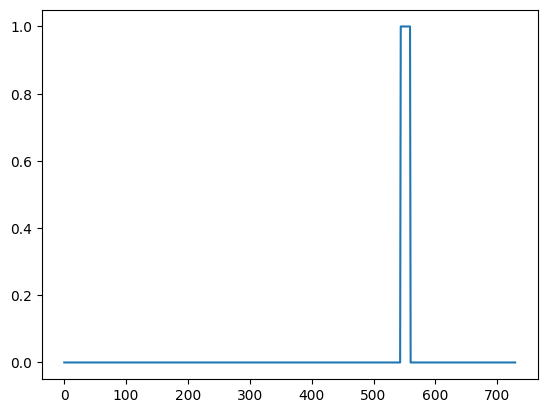

In [9]:
plt.plot(predictions[10,10][0:365*2])

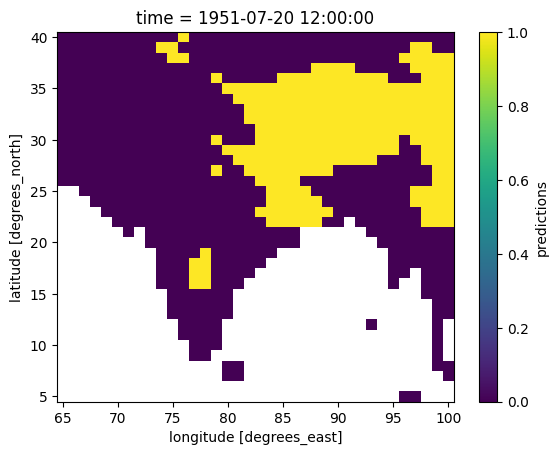

In [10]:
# Put predictions in a xarray.Dataset
predictions_xr = xr.DataArray(
    predictions,
    dims=["lat", "lon", "time"],
    coords={
        
        "lat": dataset_proj.lat,
        "lon": dataset_proj.lon,
        "time": dataset_proj.time,
    },
    name="predictions",
)

predictions_xr.isel(time=200).plot()

In [15]:
predictions_xr.to_netcdf('/home/jgrassi/work/XSeasonsDetect/INDIA/results/files/projections_prova.nc')

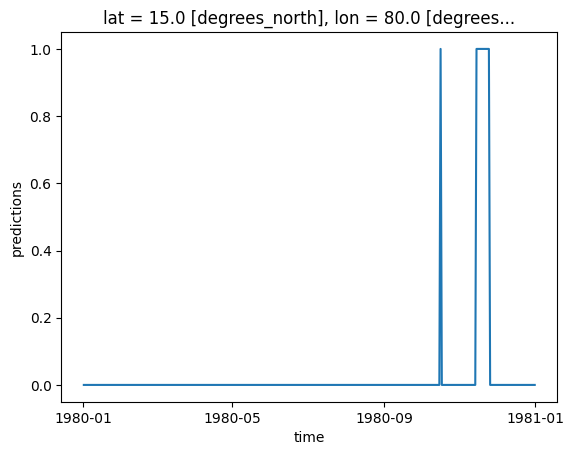

In [11]:
predictions_xr.isel(lat=10, lon=15).sel(time='1980').plot()

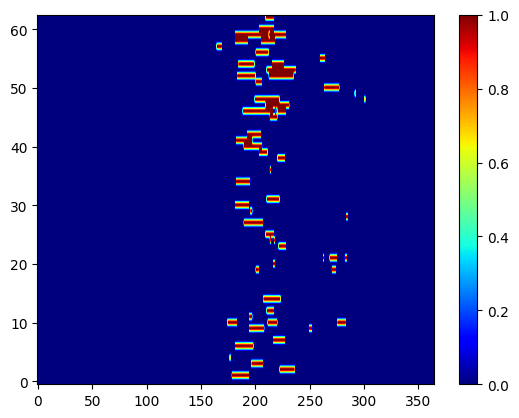

In [12]:
p = predictions_xr.isel(lat=10, lon=10)

# Assergna a p 0 se p < 0, altrimenti 1
p = np.round(p).astype(int).values
p = p.reshape(-1, 365)

plt.imshow(p, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()

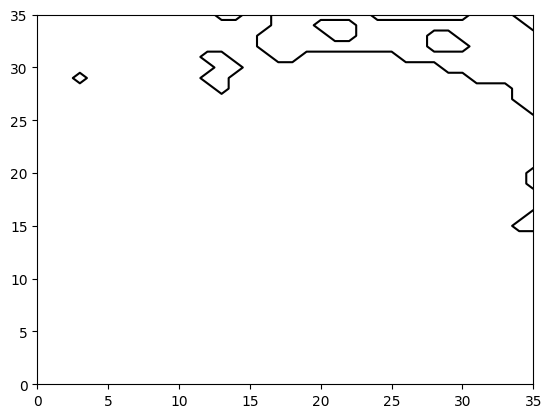

In [13]:
# contour lines
plt.contour(predictions[:,:,160], levels=[0.5], colors='black')

In [19]:
#predictions_xr_day = predictions_xr.groupby('time.dayofyear').mean('time') 

predictions_xr_day = predictions_xr.sel(time='1990')

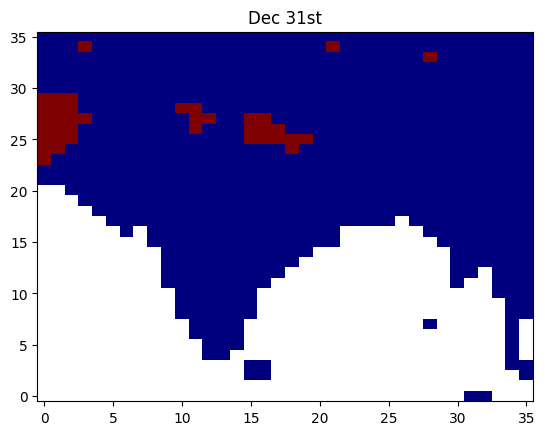

In [20]:
# Animazione matplotlib con predictions[:,:,j] con anche il contourf e imshow. Metti titolo con giorno dell'anno dinamico
import matplotlib.animation as animation


# Configura figura
fig, ax = plt.subplots()
im = ax.imshow(predictions_xr_day[:, :, 0], aspect='auto', origin='lower', cmap='jet')
contour = None
title = ax.set_title(day_of_year_to_date(0))

# Funzione di aggiornamento
def update(frame):
    global contour
    im.set_array(predictions_xr_day[:, :, frame])
    # Rimuovi vecchi contorni, se esistenti
    if contour:
        for c in contour.collections:
            c.remove()
    # Aggiungi nuovi contorni
    contour = ax.contour(predictions_xr_day[:, :, frame], levels=[0.5], colors='black')
    title.set_text(day_of_year_to_date(frame))
    return [im, *contour.collections, title]

# Creazione animazione
ani = animation.FuncAnimation(fig, update, frames=365, interval=130, blit=False)

# Mostra l'animazione
plt.show()

# Salva l'animazione in un file MP4
ani.save('predictions.mp4', writer='ffmpeg')